In [3]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

!pip install autocorrect
!pip install pandarallel
!pip install pyspellchecker
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlptwitterhatespeech/TwitterHate.csv
/kaggle/input/twitter-cleaned/twitter_cleaned.csv
     |████████████████████████████████| 622 kB 598 kB/s eta 0:00:01
  Created wheel for autocorrect: filename=autocorrect-2.5.0-py3-none-any.whl size=621854 sha256=facf14ed7781d8fa55c9eb5e73d6f647ebdd5141b6d5357ee079679aee044682
  Stored in directory: /root/.cache/pip/wheels/3d/8e/bd/f6fd900a056a031bf710a00bca338d86f43b83f0c25ab5242f
Successfully built autocorrect
     |████████████████████████████████| 2.7 MB 609 kB/s eta 0:00:01


In [5]:
import numpy as np, pandas as pd,matplotlib.pyplot as plt, seaborn as sns
sns.set()
from collections import Counter
from wordcloud import WordCloud
import re
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,  precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report
import pickle
import torch
from torch import nn

In [20]:
def save_model_to_pickle(model, model_name):
    pickle.dump(model, open(model_name, 'wb'))
 

 
def load_pickle_model(filename):
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

In [5]:
df = pd.read_csv('/kaggle/input/nlptwitterhatespeech/TwitterHate.csv', index_col=0)

In [ ]:
class TweetPreprocessor():
  def __init__(self,df:pd.DataFrame, regex_pattern:list, filter_words:list, run_autocorrect:bool,print_stripped:bool = False)-> pd.DataFrame:
    from pandarallel import pandarallel
    from spellchecker import SpellChecker
    spellcheck = SpellChecker()
    pandarallel.initialize(progress_bar=True)
    import re
    import nltk
    from nltk import  TweetTokenizer 
    from nltk.corpus import stopwords
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    tt = TweetTokenizer()
    from autocorrect import Speller
    autocorrect = Speller(lang='en')
    nltk.download('wordnet')
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    self.df = df
    self.re_pattern = regex_pattern
    #Lowercase Normalization
    self.df['tweet'] = self.df['tweet'].apply(lambda x : x.lower())
    #Remove some unwanted chars that are at the end of legit english words like â and ð
    self.df['tweet'] = self.df['tweet'].apply(lambda x: x.replace('â', ''))
    self.df['tweet'] = self.df['tweet'].apply(lambda x: x.replace('ð', ''))
    #Replace _ with space
    self.df['tweet'] = self.df['tweet'].apply(lambda x: x.replace('_', ' '))
    #Remove user handles
    self.df['tweet'] = self.df['tweet'].apply(lambda x: x.replace('@user', ''))
    #Handle contracted words
    self.df['tweet'] = self.df['tweet'].apply(lambda x: self.decontracted(x))
    #Clean noise using regex
    self.df['tweet'] = self.df['tweet'].apply(lambda x: self.regex_replacer(x,self.re_pattern))
    #Clean additional words
    self.df['tweet'] = self.df['tweet'].apply(lambda x: self.str_replacer(x, filter_words ))
    #Create tokens to do word level processing :-> df -> tokens
    self.df['tweet'] = self.df['tweet'].apply(lambda x: tt.tokenize(x))
    #Remove noise
    self.df['tweet'] = self.df['tweet'].apply(lambda x: [ i for i in x if len(i)>2])
    #Remove non apha-numeric
    self.df['tweet'] = self.df['tweet'].apply(lambda x: self.remove_non_alphanumeric(x, print_stripped))
    if run_autocorrect:
      print("Running Autocorrect this may take a while....")
      self.df['tweet'] = self.df['tweet'].parallel_apply(lambda x : self.spell_imputer(x,spellcheck, autocorrect))
    #Lemmatize
    self.df['tweet']=self.df['tweet'].apply(lambda x: self.lemma(x,lemmatizer))
    #Remove stopwords
    self.df['tweet'] = self.df['tweet'].apply(lambda w: [x for x in w if not x in stop_words])
    #create strings of list
    self.df['tweet'] = self.df['tweet'].apply(lambda x: ' '.join(x))
    #remove #
    self.df['tweet'] = self.df['tweet'].apply(lambda x: x.replace('#', ''))
    #Split it back to lists
    self.df['tweet'] = self.df['tweet'].apply(lambda x: x.split(' '))


  def decontracted(self,phrase:str)->str:
    '''Takes contracted words and returns decontracted words eg can't -> can not'''
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"y'all", "you all", phrase)
    return phrase

  def regex_replacer(self,x:str,re_pattern)->str:
    for i in re_pattern:
      x =re.sub(i, "", x)
    return x

  def str_replacer(self,x:str, filter_words:list ) ->str:
    for j in filter_words:
      x =x.replace(j,'')
    return x

  def isAlphaNumericStr(self,text:str):
   if(re.match("^[a-zA-Z0-9-_]*$", text) != None):
     return True
   else:
     return False

  def remove_non_alphanumeric(self,x:list,print_stripped:bool)-> list:
    for i in x:
      if not self.isAlphaNumericStr(str(i)) and not '#' in i:
        if print_stripped:
          print(i)
        x.remove(i)
    return list(filter(None,x))

  def spell_imputer(self,x, spellcheck, autocorrect)-> list:
    assert str(type(spellcheck)) == "<class 'spellchecker.spellchecker.SpellChecker'>", 'Requires a spellchecker object to continune'
    assert str(type(autocorrect)) == "<class 'autocorrect.Speller'>", 'Requires an autocorrect object to continune'
    misspelled = spellcheck.unknown(x)
    index_ = [x.index(i) for i in misspelled]
    for i in index_:
      x[i] = autocorrect(x[i])
      x=x
    return x

  def lemma(self,x, lem ) ->list:
    for i in x:
      x[x.index(i)] =   lem.lemmatize(i)
    return x


re_pattern = [r'\.+']
filter_words = ["amp","i'm"]
df = TweetPreprocessor(df, re_pattern, filter_words, run_autocorrect=False).df

In [ ]:
df.to_csv('./twitter_cleaned.csv')

In [ ]:
#df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x))
#df['tweet'] = df['tweet'].apply(lambda x: x.split(' '))

In [ ]:
df

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Class Label')

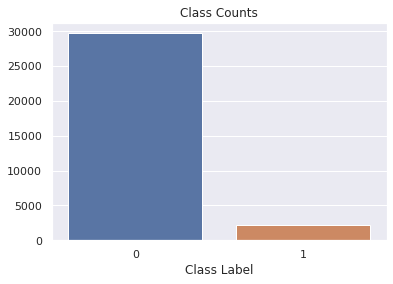

In [6]:
class_counts = df['label'].value_counts().values
class_labels = df['label'].value_counts().index
sns.barplot(class_labels,class_counts)
plt.title('Class Counts')
plt.xlabel('Class Label')

**I1: Class Imbalance is seen**

In [6]:
df = pd.read_csv('../input/twitter-cleaned/twitter_cleaned.csv', index_col=0)
df['tweet'] = df['tweet'].apply(lambda x : literal_eval(x))
df = df.dropna()
df

,label,tweet
id,,
1,0,"[father, dysfunctional, selfish, drag, kid, dy..."
2,0,"[thanks, left, credit, use, cause, offer, whee..."
3,0,"[birthday, majesty]"
4,0,"[model, love, take, time, ur]"
5,0,"[factsguide, society, motivation]"
...,...,...
31958,0,"[ate, youuu]"
31959,0,"[see, nina, turner, airwave, trying, wrap, man..."
31960,0,"[listening, sad, song, monday, morning, ots, w..."


In [8]:
hate_tweet  = df[df['label']==1].copy()
reg_tweet = df[df['label']==0].copy()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


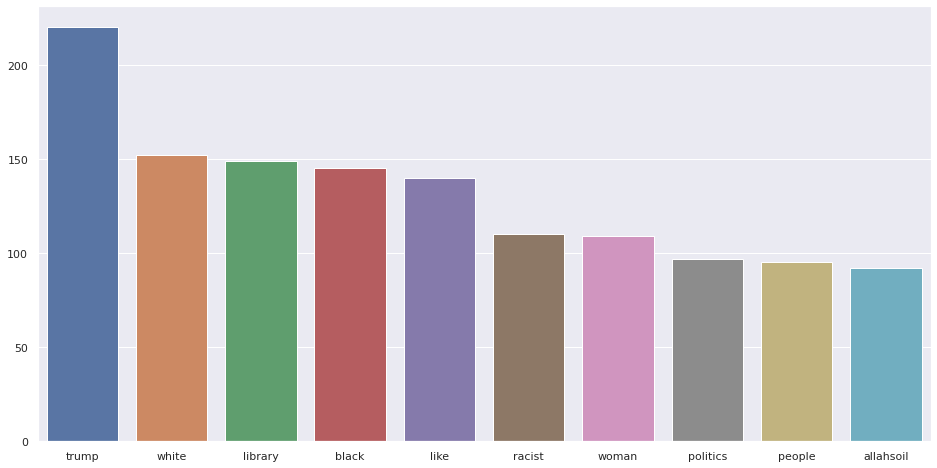

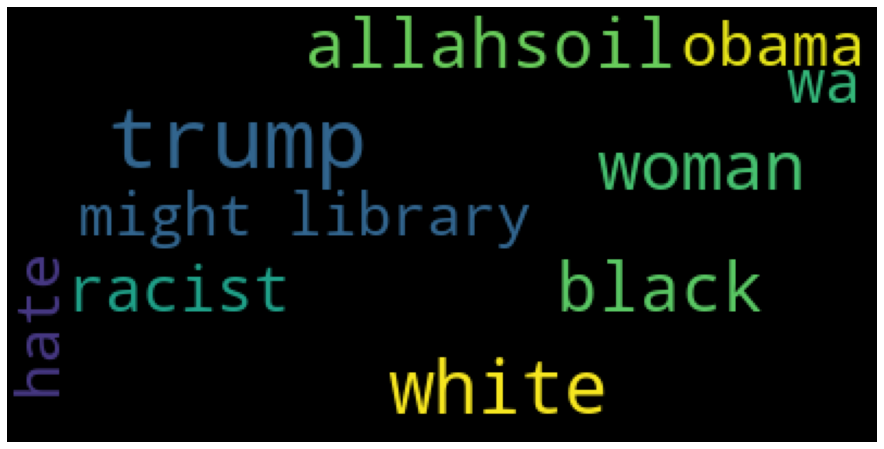

In [9]:
counter = []
for i in hate_tweet['tweet'].index:
  for j in hate_tweet['tweet'][i]:
    counter.append(j)
counter
freq_terms = Counter(counter)
word=[]
freq=[]
for i,j in freq_terms.most_common(10):
  word.append(i)
  freq.append(j)

plt.figure(figsize = (16,8))
sns.barplot(word,freq)
plt.show()
plt.figure(figsize = (16,8))
wordcloud_hate = WordCloud(background_color ='black', max_words = 10, max_font_size=40, relative_scaling =0.5).generate(" ".join(counter))
plt.imshow(wordcloud_hate)
plt.axis("off")
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


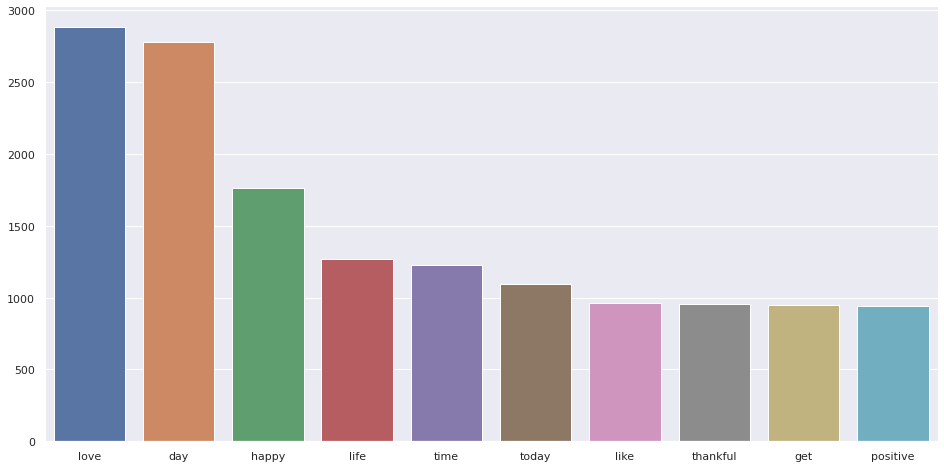

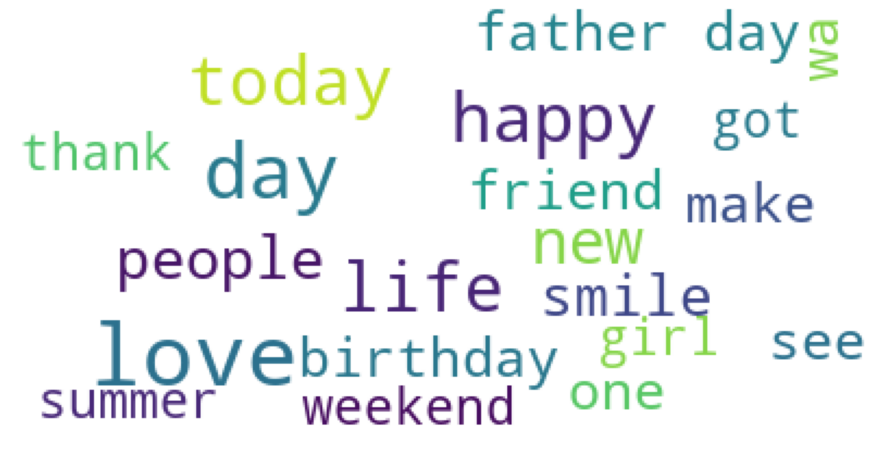

In [10]:
counter = []
for i in reg_tweet['tweet'].index:
  for j in reg_tweet['tweet'][i]:
    counter.append(j )
counter
freq_terms = Counter(counter)
word=[]
freq=[]
for i,j in freq_terms.most_common(10):
  word.append(i)
  freq.append(j)

plt.figure(figsize = (16,8))
sns.barplot(word,freq)
plt.show()

plt.figure(figsize = (16,8))
wordcloud_reg = WordCloud(background_color ='white', max_words = 20, max_font_size=40, relative_scaling =0.5).generate(" ".join(counter))
plt.imshow(wordcloud_reg)
plt.axis("off")
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['tweet'], df['label'])

In [8]:
X_train_corpus = []
for i in X_train.values:
  X_train_corpus.append(" ".join(i))
X_train_corpus

X_test_corpus = []
for i in X_test.values:
  X_test_corpus.append(" ".join(i))
X_test_corpus

['zig zag way show 2b proud top cast great backstage team lovely script awesome music encore cornish powerful funny',
 'wannabe spicegirls wannabe uk london spotify girlspower fun',
 'silent scream wattpad poem poetry poet quote writer author love',
 'waiter asks want eat plate aswell',
 'next na kayecalonweloveopm',
 'ja fish ppl blind spot knowing fight get',
 'silentsunday beach beautiful photooftheday love ocean',
 'vehicle gorilla simulator need adapt environment need tear city materia',
 'officially made white tiger cougar transition today',
 'mikesisms upset seasonal favorite',
 'wake super get legitimately pissed water lol',
 'feeling pretty good past day',
 'adele photo picture make hea adele orlando',
 'grateful father day',
 'great insight trusted profession mea growth hacking conference growthwithhubspot',
 'go home today named queen finally listening',
 'happy weekend cycle cycling bicycle weekend uk',
 'happy new clothes newclothes clothes birthday winggirlfashion fashion

In [9]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True, max_features=5000)

X_train_tfidf = tfIdfVectorizer.fit_transform(X_train_corpus).todense()
X_test_tfidf = tfIdfVectorizer.transform(X_test_corpus).todense()
X_train_tfidf = pd.DataFrame(np.array(X_train_tfidf))
X_test_tfidf = pd.DataFrame(np.array(X_test_tfidf))

In [10]:
def create_model_stat_report(YP, Y_test,model_name, df=None)->pd.DataFrame:
    if df is not None:
        df.loc[len(df.index)] = np.array([model_name,accuracy_score(YP, Y_test), precision_score(YP, Y_test), recall_score(YP, Y_test) , f1_score(YP, Y_test)])
    else:                
        df = pd.DataFrame(np.array([model_name,accuracy_score(YP, Y_test), precision_score(YP, Y_test), recall_score(YP, Y_test) , f1_score(YP, Y_test)]).reshape(1,-1))
        df.columns = ['Model','Accuracy', 'Precision','Recall','F-1 Score']
    return df

In [15]:
X_train_tfidf.shape, X_test_tfidf.shape

((23971, 5000), (7991, 5000))

In [16]:
Base_LR = LogisticRegression(C=100,max_iter=100000,verbose=10, n_jobs=-1)
Base_LR.fit(X_train_tfidf, Y_train)
YP = Base_LR.predict(X_test_tfidf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 15.8min finished


In [17]:
model_stat = create_model_stat_report(YP, Y_test,'Logistic Regression')
model_stat

,Model,Accuracy,Precision,Recall,F-1 Score
0,Logistic Regression,0.954699036415968,0.5988593155893536,0.6759656652360515,0.6350806451612903


In [23]:
save_model_to_pickle(Base_LR, './Base_LR.sav')

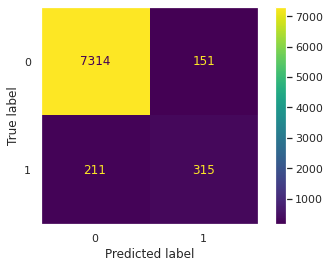

In [24]:
with sns.axes_style('dark'):
    plot_confusion_matrix(load_pickle_model('./Base_LR.sav'), X = X_test_tfidf, y_true= Y_test)

Although accuracy is 95% Precision is 61% so of the actual positives 61% has been correctly labeled this needs to be improved

Try handling class imbalance problem


In [27]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3,shuffle=True, random_state=7)
model = LogisticRegression(C=100,max_iter=1000,verbose=True, n_jobs=-1)


def training(x_train, x_test,y_train,y_test ,fold_no,model):
  model.fit(x_train, y_train)
  score = model.score(x_test,y_test)
  print('Fold {} -> accuracy: {:.2F}% | F1-Score: {:.2F}'.format(str(fold_no),score*100, f1_score(model.predict(x_test),y_test)))

fold_no = 1
for train_index,test_index in skf.split(X_train_tfidf, Y_train):
  x_train = X_train_tfidf.iloc[train_index]
  x_test = X_train_tfidf.iloc[test_index]
  y_train = Y_train.iloc[train_index]
  y_test = Y_train.iloc[test_index]
  training(x_train, x_test, y_train,y_test, fold_no,model)
  fold_no += 1




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 11.3min finished


Fold 1 -> accuracy: 95.38% | F1-Score: 0.66


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 10.1min finished


Fold 2 -> accuracy: 95.16% | F1-Score: 0.62


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 12.4min finished


Fold 3 -> accuracy: 95.28% | F1-Score: 0.64


In [28]:
save_model_to_pickle(model, './LR_k_fold_model.sav')

Decision Tree

In [29]:
dtreeclassifier_base = DecisionTreeClassifier()
dtreeclassifier_base.fit(X_train_tfidf,Y_train)
YP = dtreeclassifier_base.predict(X_test_tfidf)
model_stat = create_model_stat_report(YP, Y_test,'dtreeclassifier_base',model_stat)

In [32]:
model_stat

,Model,Accuracy,Precision,Recall,F-1 Score
0,Logistic Regression,0.954699036415968,0.5988593155893536,0.6759656652360515,0.6350806451612903
1,dtreeclassifier_base,0.948942560380428,0.6121673003802282,0.6121673003802282,0.6121673003802282


In [31]:
save_model_to_pickle(dtreeclassifier_base, './dtreeclassifier_base.sav')

In [33]:
randomforest_base = RandomForestClassifier()
randomforest_base.fit(X_train_tfidf,Y_train)
YP = randomforest_base.predict(X_test_tfidf)
model_stat = create_model_stat_report(YP, Y_test,'randomforest_base',model_stat)
model_stat

,Model,Accuracy,Precision,Recall,F-1 Score
0,Logistic Regression,0.954699036415968,0.5988593155893536,0.6759656652360515,0.6350806451612903
1,dtreeclassifier_base,0.948942560380428,0.6121673003802282,0.6121673003802282,0.6121673003802282
2,randomforest_base,0.9632086096858966,0.5627376425855514,0.8222222222222222,0.6681715575620767


In [34]:
save_model_to_pickle(randomforest_base, './randomforest_base.sav')

In [35]:
xgbc_base  = xgb.XGBClassifier()
xgbc_base.fit(X_train_tfidf,Y_train)
YP = xgbc_base.predict(X_test_tfidf)
model_stat = create_model_stat_report(YP, Y_test,'xgbc_base',model_stat)
model_stat

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:30:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Accuracy,Precision,Recall,F-1 Score
0,Logistic Regression,0.954699036415968,0.5988593155893536,0.6759656652360515,0.6350806451612903
1,dtreeclassifier_base,0.948942560380428,0.6121673003802282,0.6121673003802282,0.6121673003802282
2,randomforest_base,0.9632086096858966,0.5627376425855514,0.8222222222222222,0.6681715575620767
3,xgbc_base,0.9553247403328745,0.38783269961977185,0.8535564853556485,0.5333333333333333


In [36]:
save_model_to_pickle(xgbc_base, './xgbc_base.sav')

In [37]:
naive_bayes_base = MultinomialNB()
naive_bayes_base.fit(X_train_tfidf,Y_train)
YP = naive_bayes_base.predict(X_test_tfidf)
model_stat = create_model_stat_report(YP, Y_test,'Naive_Bayes_base',model_stat)

In [38]:
save_model_to_pickle(naive_bayes_base, './naive_bayes_base.sav')

In [39]:
svc_base = SVC()
svc_base.fit(X_train_tfidf,Y_train)
YP = svc_base.predict(X_test_tfidf)
model_stat = create_model_stat_report(YP, Y_test,'svc_base',model_stat)

In [40]:
save_model_to_pickle(svc_base, './svc_base.sav')

In [41]:
model_stat

,Model,Accuracy,Precision,Recall,F-1 Score
0,Logistic Regression,0.954699036415968,0.5988593155893536,0.6759656652360515,0.6350806451612903
1,dtreeclassifier_base,0.948942560380428,0.6121673003802282,0.6121673003802282,0.6121673003802282
2,randomforest_base,0.9632086096858966,0.5627376425855514,0.8222222222222222,0.6681715575620767
3,xgbc_base,0.9553247403328745,0.38783269961977185,0.8535564853556485,0.5333333333333333
4,Naive_Bayes_base,0.9529470654486297,0.31368821292775667,0.9166666666666666,0.46742209631728054
5,svc_base,0.9610812163684145,0.44106463878326996,0.9317269076305221,0.5987096774193549


In [ ]:
X_test_tfidf_tensor = torch.tensor(X_test_tfidf)
X_train_tfidf_tensor = torch.tensor(X_train_tfidf)
Y_train_tensor = torch.tensor(Y_train.values.reshape(-1,1))
Y_test_tensor = torch.tensor(Y_test.values.reshape(-1,1))

In [ ]:
model_stat

Random Forest model seems to do better than the rest but has bad precision

In [ ]:
LR  = LogisticRegression()

parameters = {
              'C': [10, 50, 100], 
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
              }

lr_grid = GridSearchCV(LR,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)

lr_grid.fit(X_train_tfidf,Y_train)

print(lr_grid.best_score_)
print(lr_grid.best_params_)

YP = lr_grid.predict(X_test_tfidf)
grid_model_stat = create_model_stat_report(YP, Y_test,'LR_grid')
grid_model_stat

USE NGRAMS and see if there is any improvement 

In [11]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True, max_features=5000,ngram_range=(1,3) )

X_train_tfidf = tfIdfVectorizer.fit_transform(X_train_corpus).todense()
X_test_tfidf = tfIdfVectorizer.transform(X_test_corpus).todense()
X_train_tfidf = pd.DataFrame(np.array(X_train_tfidf))
X_test_tfidf = pd.DataFrame(np.array(X_test_tfidf))
X_test_tfidf.describe()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
count,7991.0,7991.000000,7991.000000,7991.0,7991.000000,7991.000000,7991.000000,7991.000000,7991.000000,7991.000000,...,7991.000000,7991.000000,7991.000000,7991.0,7991.000000,7991.0,7991.000000,7991.00000,7991.000000,7991.000000
mean,0.0,0.000162,0.000122,0.0,0.001647,0.000111,0.000075,0.000625,0.000069,0.000069,...,0.000348,0.000238,0.000247,0.0,0.000047,0.0,0.000104,0.00115,0.000269,0.000074
std,0.0,0.009060,0.006296,0.0,0.026612,0.006999,0.006735,0.015620,0.004340,0.004340,...,0.014038,0.010916,0.011062,0.0,0.004207,0.0,0.009310,0.02499,0.011024,0.004691
min,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000
max,0.0,0.683683,0.349749,0.0,1.000000,0.450008,0.602065,0.694199,0.274379,0.274379,...,0.678977,0.654615,0.532538,0.0,0.376110,0.0,0.832257,0.75275,0.555783,0.309058


In [12]:
Base_LR_ngrams = LogisticRegression(C=50,max_iter=100000,verbose=10, n_jobs=-1)
Base_LR_ngrams.fit(X_train_tfidf, Y_train)
YP = Base_LR_ngrams.predict(X_test_tfidf)
model_stat = create_model_stat_report(YP, Y_test,'Logistic Regression ngram')
model_stat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.1min finished


,Model,Accuracy,Precision,Recall,F-1 Score
0,Logistic Regression ngram,0.9520710799649605,0.5931899641577061,0.6796714579055442,0.6334928229665071


In [20]:
randomforest_base_ngrams = RandomForestClassifier()
randomforest_base_ngrams.fit(X_train_tfidf,Y_train)
YP = randomforest_base_ngrams.predict(X_test_tfidf)
model_stat = create_model_stat_report(YP, Y_test,'randomforest_base_ngrams',model_stat)
model_stat

,Model,Accuracy,Precision,Recall,F-1 Score
0,Logistic Regression ngram,0.9420598172944563,0.5888501742160279,0.5982300884955752,0.5935030728709395
1,randomforest_base_ngrams,0.9577024152171193,0.5,0.849112426035503,0.6293859649122807
